<a href="https://colab.research.google.com/github/Rohith-Rongali/IMP/blob/main/IMP_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.utils.prune as prune

from copy import deepcopy

from tqdm import tqdm
import os

import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace

# Data functions

In [2]:
def generate_points(num=40000,dim=18,type='normal',normal_var=1,radius=1):
    '''
    If type=='normal', then generate points from N(0,normal_var)
    If type=='spherical', then simply divide the points by their norm.'''
    X = torch.randn([num,dim]) #coordinates sampled from N(0,1)

    if type=='spherical':
      norm = torch.norm(X, p=2, dim=1, keepdim=True)
      X_spherical = X / norm
      return X_spherical

    elif type=='normal':
      return X

    else:
      raise ValueError('type should be either normal or spherical')


class TreeNode:
    '''
    This class represents a node in the decision tree.
    Each node has a depth, a maximum depth(of the tree), a feature index, and left and right child nodes.
    Leaf nodes have a value, which is the predicted class.
    '''
    def __init__(self, depth, max_depth, feature_index):
        self.depth = depth
        self.max_depth = max_depth
        self.feature = feature_index
        self.left = None
        self.right = None
        self.value = None  # This will store the predicted class for leaf nodes

    def build_tree(self):
        if self.depth == self.max_depth:
            self.value = float(self.feature % 2)
            return

        # Create left and right child nodes
        self.left = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+1)
        self.right = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+2)

        # Recursively build left and right subtrees
        self.left.build_tree()
        self.right.build_tree()

    def predict(self, x):
        if self.value is not None:
            return self.value

        if x[self.feature] > 0:
            return self.left.predict(x)
        else:
            return self.right.predict(x)


def gen_std_basis_DT(depth, dim_in, type_data, num_points, feat_index_start=0,radius=1):
    '''
    Generate points uniformly random from a hypersphere. And the label is the prediction of the tree with depth = max_depth.
    The node hyperplanes are simply characterised by standard basis vectors(for example, the root node hyperplane is x[0] = 0)

    '''
    Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
    Tree.build_tree()
    X = generate_points(num=num_points,dim=dim_in,type=type_data,radius=radius)

    Y=[]
    for item in X:
        Y.append(Tree.predict(item))

    Y = torch.tensor(Y)
    return X,Y




def set_npseed(seed):
	np.random.seed(seed)


def set_torchseed(seed):
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False



# depth = 4
# dim_in = 18
# type_data = 'normal'
# feat_index_start = 0 #the index of the first feature in the tree
# num_points = 40000


#     Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
#     Tree.build_tree()
#     X = generate_points(num=num_points,dim=dim_in,type=type_data)

#     Y=[]
#     for item in X:
#     Y.append(Tree.predict(item))

#     Y = torch.tensor(Y)

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        sample_y = self.y[idx]

        if self.transform:
            sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y

def return_data_elements(DataConfig):
    # returns [data] and data_loader

    x_train,y_train = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    x_test,y_test = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    # x_train, x_test, y_train, y_test = train_test_split(
    # X, Y, test_size=0.1, random_state=42, stratify=Y)

    data = [x_train,y_train.long(),x_test,y_test.long()]

    return data

def loaders(data,batch_size=32):
    x_train,y_train,x_test,y_test = data
    train_dataset = CustomDataset(x_train, y_train)
    test_dataset = CustomDataset(x_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

# Models


In [3]:
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, width, depth):
        super(DNN, self).__init__()
        self.depth = depth
        self.layers = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width) for i in range(self.depth)])
        self.output_layer = nn.Linear(width, dim_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

# Configs

In [5]:

model_config = SimpleNamespace(
    width=256,
    depth=2
)

data_config = SimpleNamespace(
    dim_in=100,
    depth=4,
    type_data='spherical',
    num_points=60000,
    radius=1,
    dim_out=2
)

train_config = SimpleNamespace(
    batch_size=32,
    lr=0.01,
    epochs=100
)


# Training

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [13]:
data= return_data_elements(data_config)
x_train,y_train,x_test,y_test = data

In [14]:
# Create DataLoaders for train and test datasets
batch_size = 32

# Assuming you have a custom Dataset class, you can create instances like this:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)

In [16]:
def train(model,loss_fn,optimizer,train_dataloader,
          data,num_epochs=train_config.epochs,log_epochs=10,log_acc=10,thresh=1e-5,print_std=True):
  [x_train,y_train,x_test,y_test]=data
  model.to(device)
  Train_losses=[]
  acc_dict = {'train':[],'test':[]}
  for epoch in range(num_epochs):
      model.train()
      for x_batch, y_batch in train_dataloader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          pred = model(x_batch)
          loss = loss_fn(pred, y_batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


      if epoch % log_epochs == 0:
          loss_full = loss_fn(model(x_train.to(device)),y_train.to(device))
          Train_losses.append(loss_full.item())
          print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
      if log_acc!=0:
        if epoch % log_acc == 0:
          train_pred = model(x_train.to(device))
          pred = torch.argmax(model(x_train.to(device)),dim=1)
          zero_mask = (pred-y_train.to(device) == 0.0)
          train_acc = zero_mask.sum().item()/len(y_train)
          acc_dict['train'].append(train_acc)

          test_pred = model(x_test.to(device))[:,0]
          pred = torch.argmax(model(x_test.to(device)),dim=1)
          zero_mask = (pred-y_test.to(device) == 0.0)
          test_acc = zero_mask.sum().item()/len(y_test)
          acc_dict['test'].append(test_acc)

          if print_std:
            print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}')
      if loss_full.item() < thresh:
          print(f'Early stopping at epoch {epoch} because loss is below 0.01')
          break

  return Train_losses,acc_dict

In [17]:
losses, acc_dict = train(model,loss_fn,optimizer,train_dataloader,data)

Epoch 0 Loss 0.5745
Epoch 0 train_acc 0.70375 test_acc 0.6797333333333333
Epoch 10 Loss 0.1822
Epoch 10 train_acc 0.9298333333333333 test_acc 0.7782333333333333
Epoch 20 Loss 0.1100
Epoch 20 train_acc 0.9579833333333333 test_acc 0.7799833333333334
Epoch 30 Loss 0.0767
Epoch 30 train_acc 0.97135 test_acc 0.7811666666666667
Epoch 40 Loss 0.0676
Epoch 40 train_acc 0.97575 test_acc 0.7840666666666667
Epoch 50 Loss 0.0716
Epoch 50 train_acc 0.9755 test_acc 0.7831333333333333
Epoch 60 Loss 0.0671
Epoch 60 train_acc 0.9793833333333334 test_acc 0.7839833333333334
Epoch 70 Loss 0.0754
Epoch 70 train_acc 0.9793166666666666 test_acc 0.7823833333333333
Epoch 80 Loss 0.0544
Epoch 80 train_acc 0.9845666666666667 test_acc 0.7877333333333333
Epoch 90 Loss 0.0389
Epoch 90 train_acc 0.9883833333333333 test_acc 0.7886


## Large learning rate schedule

In [14]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


## Pruning

So far everything is the same. I set the pruning rate as $p ^ {1/n}$, this still works to some extent... Not sure how? I think we should still figure out some other schemes, maybe we can threshold the weights instead of removing a certain amount of smaller magnitude weights.... could try constant pruning fraction as well....

In [1]:
# To compare pruning rate heuristics
for i in [0.1,0.2,0.3,0.4]:
    x=1
    print(' ')
    print(f'pruning rate={i}')
    for j in range(1,21):
        print(f'Pruning {j} {x*(1-i**(1/j))} {(1-i)**j}')


 
pruning rate=0.1
Pruning 1 0.9 0.9
Pruning 2 0.683772233983162 0.81
Pruning 3 0.535841116638722 0.7290000000000001
Pruning 4 0.4376586748096509 0.6561
Pruning 5 0.36904265551980675 0.5904900000000001
Pruning 6 0.31870793094203864 0.531441
Pruning 7 0.28031432699884795 0.4782969000000001
Pruning 8 0.2501057906675441 0.4304672100000001
Pruning 9 0.2257363173188729 0.3874204890000001
Pruning 10 0.2056717652757185 0.3486784401000001
Pruning 11 0.18886916921031294 0.31381059609000006
Pruning 12 0.1745958147319816 0.2824295364810001
Pruning 13 0.16232235993170807 0.2541865828329001
Pruning 14 0.15165710175592795 0.2287679245496101
Pruning 15 0.14230410140910588 0.20589113209464907
Pruning 16 0.13403567663993465 0.18530201888518416
Pruning 17 0.12667383761715667 0.16677181699666577
Pruning 18 0.12007745643089296 0.15009463529699918
Pruning 19 0.11413320958991735 0.13508517176729928
Pruning 20 0.10874906186625444 0.12157665459056935
 
pruning rate=0.2
Pruning 1 0.8 0.8
Pruning 2 0.5527864045

In [18]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)

In [19]:
INITIAL_WEIGHTS = deepcopy(model.state_dict())
prune_epochs=6
p = 0.2
losses = {}
acc_dict = {}
for n in tqdm(range(1, prune_epochs + 1), total=prune_epochs, leave=False):

  losses[n], acc_dict[n] = train(model,loss_fn,optimizer,train_dataloader,data)

  pruning_rate = p ** (1 / n)

  # Prune the model
  prune.l1_unstructured(model.layers[0], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.layers[1], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.output_layer, name="weight", amount=pruning_rate/2)

  # Reset weights
  reseted_weights = deepcopy(model.state_dict())
  for param in reseted_weights.keys():
      if param.split(".")[-1].replace("_orig", "") in ("bias", "weight"):
          reseted_weights[param] = deepcopy(INITIAL_WEIGHTS[param.replace("_orig", "")])
  if n< prune_epochs-1:
    model.load_state_dict(reseted_weights)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0 Loss 0.5714
Epoch 0 train_acc 0.7024166666666667 test_acc 0.6766666666666666
Epoch 10 Loss 0.1536
Epoch 10 train_acc 0.93955 test_acc 0.7992833333333333
Epoch 20 Loss 0.0934
Epoch 20 train_acc 0.96455 test_acc 0.7982666666666667
Epoch 30 Loss 0.0545
Epoch 30 train_acc 0.9791833333333333 test_acc 0.8057833333333333
Epoch 40 Loss 0.0715
Epoch 40 train_acc 0.9755 test_acc 0.8076833333333333
Epoch 50 Loss 0.0608
Epoch 50 train_acc 0.9808833333333333 test_acc 0.80795
Epoch 60 Loss 0.0777
Epoch 60 train_acc 0.9764166666666667 test_acc 0.80625
Epoch 70 Loss 0.0533
Epoch 70 train_acc 0.9826333333333334 test_acc 0.8088833333333333
Epoch 80 Loss 0.0429
Epoch 80 train_acc 0.9864166666666667 test_acc 0.8076333333333333
Epoch 90 Loss 0.0411
Epoch 90 train_acc 0.9877666666666667 test_acc 0.8122333333333334


 17%|█▋        | 1/6 [05:07<25:37, 307.54s/it]

Epoch 0 Loss 0.5680
Epoch 0 train_acc 0.707 test_acc 0.6841666666666667
Epoch 10 Loss 0.1177
Epoch 10 train_acc 0.9570666666666666 test_acc 0.85495
Epoch 20 Loss 0.0855
Epoch 20 train_acc 0.96935 test_acc 0.8505166666666667
Epoch 30 Loss 0.0453
Epoch 30 train_acc 0.9842 test_acc 0.8645
Epoch 40 Loss 0.0390
Epoch 40 train_acc 0.98705 test_acc 0.8705666666666667
Epoch 50 Loss 0.0382
Epoch 50 train_acc 0.9890666666666666 test_acc 0.87175
Epoch 60 Loss 0.0390
Epoch 60 train_acc 0.9891166666666666 test_acc 0.8736833333333334
Epoch 70 Loss 0.0399
Epoch 70 train_acc 0.9896 test_acc 0.8741333333333333
Epoch 80 Loss 0.0236
Epoch 80 train_acc 0.99345 test_acc 0.8802833333333333
Epoch 90 Loss 0.0237
Epoch 90 train_acc 0.9934666666666667 test_acc 0.8797


 33%|███▎      | 2/6 [10:01<19:57, 299.29s/it]

Epoch 0 Loss 0.5071
Epoch 0 train_acc 0.7523333333333333 test_acc 0.7408166666666667
Epoch 10 Loss 0.1313
Epoch 10 train_acc 0.94885 test_acc 0.9108
Epoch 20 Loss 0.0666
Epoch 20 train_acc 0.9748166666666667 test_acc 0.9221833333333334
Epoch 30 Loss 0.0474
Epoch 30 train_acc 0.9829666666666667 test_acc 0.9255333333333333
Epoch 40 Loss 0.0383
Epoch 40 train_acc 0.9861666666666666 test_acc 0.92595
Epoch 50 Loss 0.0316
Epoch 50 train_acc 0.9899166666666667 test_acc 0.9283166666666667
Epoch 60 Loss 0.0242
Epoch 60 train_acc 0.9924166666666666 test_acc 0.9267666666666666
Epoch 70 Loss 0.0264
Epoch 70 train_acc 0.9914666666666667 test_acc 0.9260333333333334
Epoch 80 Loss 0.0245
Epoch 80 train_acc 0.9927 test_acc 0.9280333333333334
Epoch 90 Loss 0.0362
Epoch 90 train_acc 0.9894333333333334 test_acc 0.9254666666666667


 50%|█████     | 3/6 [14:30<14:17, 285.75s/it]

Epoch 0 Loss 0.5239
Epoch 0 train_acc 0.74215 test_acc 0.7321666666666666
Epoch 10 Loss 0.1184
Epoch 10 train_acc 0.9572333333333334 test_acc 0.9440833333333334
Epoch 20 Loss 0.0635
Epoch 20 train_acc 0.9770833333333333 test_acc 0.96
Epoch 30 Loss 0.0431
Epoch 30 train_acc 0.9853166666666666 test_acc 0.9641166666666666
Epoch 40 Loss 0.0411
Epoch 40 train_acc 0.98545 test_acc 0.9630333333333333
Epoch 50 Loss 0.0453
Epoch 50 train_acc 0.9869666666666667 test_acc 0.96435
Epoch 60 Loss 0.0359
Epoch 60 train_acc 0.9872333333333333 test_acc 0.9655833333333333
Epoch 70 Loss 0.0327
Epoch 70 train_acc 0.9900666666666667 test_acc 0.9650833333333333
Epoch 80 Loss 0.0277
Epoch 80 train_acc 0.9911666666666666 test_acc 0.9660333333333333
Epoch 90 Loss 0.0353
Epoch 90 train_acc 0.9899833333333333 test_acc 0.9658


 67%|██████▋   | 4/6 [18:53<09:13, 276.62s/it]

Epoch 0 Loss 0.5699
Epoch 0 train_acc 0.7052333333333334 test_acc 0.6991
Epoch 10 Loss 0.1965
Epoch 10 train_acc 0.9232333333333334 test_acc 0.9156333333333333
Epoch 20 Loss 0.1897
Epoch 20 train_acc 0.9276666666666666 test_acc 0.9220666666666667
Epoch 30 Loss 0.1504
Epoch 30 train_acc 0.94545 test_acc 0.9394
Epoch 40 Loss 0.1336
Epoch 40 train_acc 0.9506666666666667 test_acc 0.94175
Epoch 50 Loss 0.1326
Epoch 50 train_acc 0.94925 test_acc 0.9429666666666666
Epoch 60 Loss 0.1277
Epoch 60 train_acc 0.9519666666666666 test_acc 0.9454833333333333
Epoch 70 Loss 0.1286
Epoch 70 train_acc 0.9511166666666667 test_acc 0.94195
Epoch 80 Loss 0.1215
Epoch 80 train_acc 0.9537333333333333 test_acc 0.9473
Epoch 90 Loss 0.1277
Epoch 90 train_acc 0.9564166666666667 test_acc 0.9470666666666666


 83%|████████▎ | 5/6 [23:47<04:42, 282.85s/it]

Epoch 0 Loss 0.0864
Epoch 0 train_acc 0.9682833333333334 test_acc 0.9624833333333334
Epoch 10 Loss 0.0805
Epoch 10 train_acc 0.9719666666666666 test_acc 0.967
Epoch 20 Loss 0.0715
Epoch 20 train_acc 0.975 test_acc 0.96985
Epoch 30 Loss 0.0814
Epoch 30 train_acc 0.9726833333333333 test_acc 0.9670166666666666
Epoch 40 Loss 0.0884
Epoch 40 train_acc 0.9709333333333333 test_acc 0.96555
Epoch 50 Loss 0.0593
Epoch 50 train_acc 0.97935 test_acc 0.9739166666666667
Epoch 60 Loss 0.0842
Epoch 60 train_acc 0.9720833333333333 test_acc 0.9661833333333333
Epoch 70 Loss 0.0780
Epoch 70 train_acc 0.9763166666666667 test_acc 0.9701666666666666
Epoch 80 Loss 0.0797
Epoch 80 train_acc 0.97245 test_acc 0.9670666666666666
Epoch 90 Loss 0.0723
Epoch 90 train_acc 0.9754 test_acc 0.97


## Probing

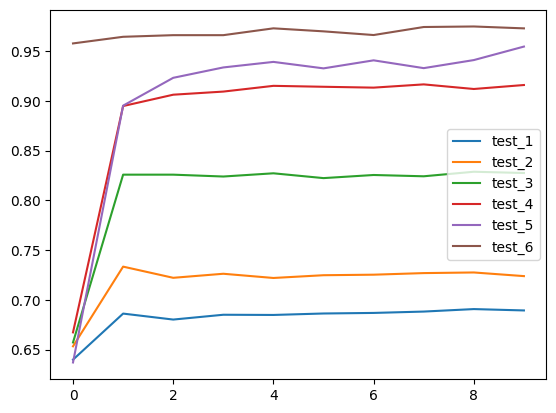

In [12]:
#plot acc_dict(test)
plt.figure()
for key in acc_dict.keys():
#   plt.plot(acc_dict[key]['train'],label=f'train_{key}')
  plt.plot(acc_dict[key]['test'],label=f'test_{key}')
plt.legend()

Text(0, 0.5, 'Final accuracy')

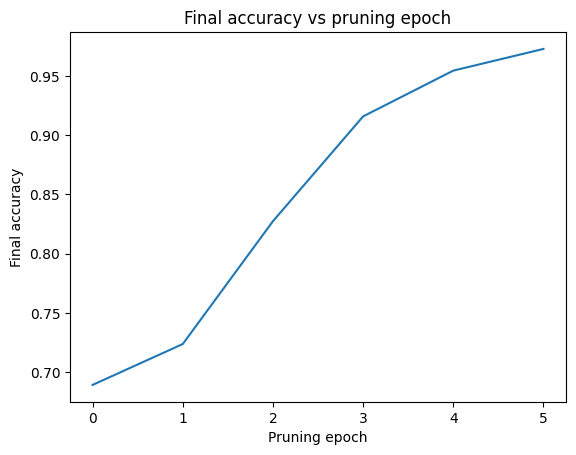

In [13]:
final_acc_list = [acc_dict[key]['test'][-1] for key in acc_dict.keys()]
plt.figure()
plt.plot(final_acc_list)
plt.title('Final accuracy vs pruning epoch')
plt.xlabel('Pruning epoch')
plt.ylabel('Final accuracy')

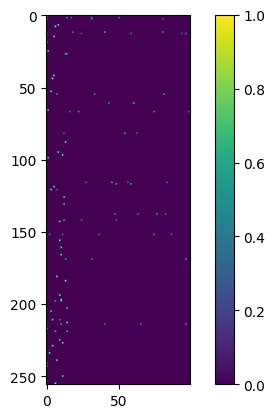

In [14]:
#normalise weights1 row-wise
wt_mat = model.layers[0].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()

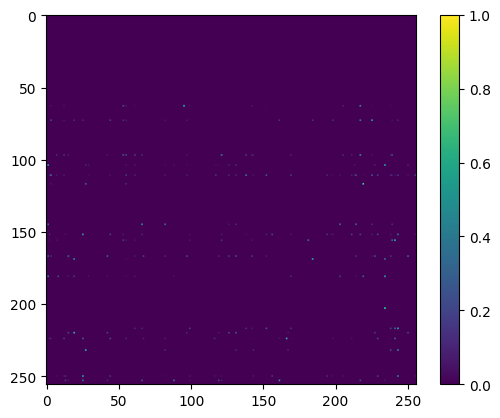

In [15]:
#normalise weights1 row-wise
wt_mat = model.layers[1].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()